In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/siamese-registration')

In [4]:
from datasets import RandomTransformationDataset
from models import *

In [5]:
path = "/content/drive/MyDrive/data"
output_path = "/content/drive/MyDrive/outputs"


In [6]:
train_dataset = RandomTransformationDataset(
    transforms=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]),
    path=os.path.join(path, "train.pkl"),
    path_prefix="/content/drive/MyDrive"
)

test_dataset = RandomTransformationDataset(
    transforms=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]),
    path=os.path.join(path, "test.pkl"),
    path_prefix="/content/drive/MyDrive"
)


In [7]:
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=5, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
model = siamese_resnet18(1, 7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
model.to(device=device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Running on cuda


In [9]:
training_loss = []
validation_loss = []

for epoch in range(0, 10):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, unit="batch") as progress:
        for img0, img1, params in progress:
            progress.set_description(f"Epoch {epoch} - train")
            img0, img1, params = img0.to(device=device), img1.to(device=device), params.to(device=device)
            optimizer.zero_grad()
            outputs = model(img0, img1)
            loss = criterion(outputs, params)
            loss_item = loss.item()
            running_loss += loss_item
            loss.backward()
            optimizer.step()
            progress.set_postfix(loss=loss_item)

    training_loss.append(running_loss / len(train_loader))

    model.eval()
    val_running_loss = 0.0
    with tqdm(test_loader, unit="batch") as validation_progress:
        for img0, img1, params in validation_progress:
            validation_progress.set_description(f"Epoch {epoch} - validation")
            img0, img1, params = img0.to(device=device), img1.to(device=device), params.to(device=device)
            outputs = model(img0, img1)
            loss = criterion(outputs, params)
            loss_item = loss.item()
            val_running_loss += loss_item
            validation_progress.set_postfix(loss=loss_item)

    validation_loss.append(val_running_loss / len(test_loader))

    torch.save(model.state_dict(), os.path.join(output_path, f"model-{epoch}.pt"))

    plt.figure()
    plt.plot(training_loss, label="training loss")
    plt.plot(validation_loss, label="validation loss")
    plt.title("Training loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(os.path.join(output_path, "loss.png"))
    plt.close()

  0%|          | 0/1000 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch 9 - validation: 100%|██████████| 1000/1000 [07:24<00:00,  2.25batch/s, loss=14.5]


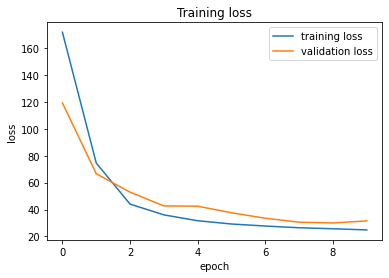

In [16]:
plt.figure()
plt.plot(training_loss, label="training loss")
plt.plot(validation_loss, label="validation loss")
plt.title("Training loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()